In [36]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import r2_score

# start_date = datetime(2023, 11, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
# end_date = datetime(2023, 11, 28, 15, 59, 59).replace(tzinfo=timezone.utc)
# system_ids = [18]

start_date = datetime(2023, 12, 1, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 12, 22, 23, 59, 59).replace(tzinfo=timezone.utc)
system_ids = [10,12,16,18,20]
#system_ids = [18]


DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")


In [37]:
def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)

In [38]:
df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet")) \
    .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

# Perform RANSAC only on slope and then select valid calibrations

In [39]:
df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [40]:
def fit_ransac(x, y, date):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)
    T = np.array(date)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.01)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

In [41]:
df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-12").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp
date,str,f64,f64,"datetime[μs, UTC]",f64
2023-12-01,"""tum-esm-midcos…",0.995592,27.799895,2023-12-01 05:20:46.340 UTC,472613.346206
2023-12-02,"""tum-esm-midcos…",0.995499,26.994858,2023-12-02 06:01:12.140 UTC,472638.020039
2023-12-03,"""tum-esm-midcos…",0.995938,26.992405,2023-12-03 07:18:42.500 UTC,472663.311806
2023-12-04,"""tum-esm-midcos…",0.996929,26.585057,2023-12-04 08:32:19.210 UTC,472688.538669
2023-12-05,"""tum-esm-midcos…",0.997338,26.689198,2023-12-05 09:20:20.380 UTC,472713.338994
2023-12-06,"""tum-esm-midcos…",0.99568,27.151802,2023-12-06 10:01:47.970 UTC,472738.029992
2023-12-07,"""tum-esm-midcos…",1.000101,25.076424,2023-12-07 11:20:05.760 UTC,472763.334933
2023-12-08,"""tum-esm-midcos…",0.995768,27.158504,2023-12-08 13:08:23.890 UTC,472789.139969
2023-12-09,"""tum-esm-midcos…",1.036542,11.819121,2023-12-09 13:20:06.660 UTC,472813.335183


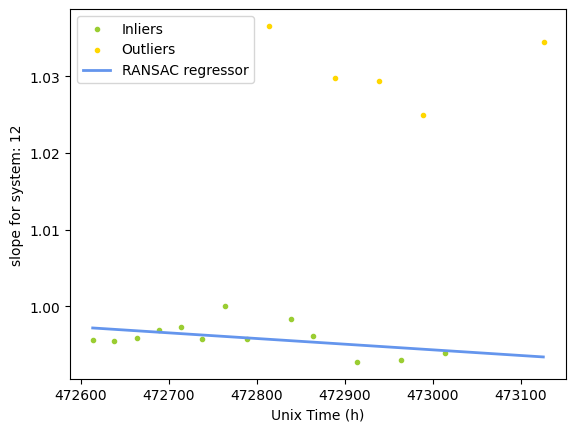

shape: (18, 7)
┌────────────┬───────────────────┬──────────┬───────────┬──────────────────┬───────────────┬───────┐
│ date       ┆ system_name       ┆ slope    ┆ intercept ┆ creation_timesta ┆ timestamp     ┆ mask  │
│ ---        ┆ ---               ┆ ---      ┆ ---       ┆ mp               ┆ ---           ┆ ---   │
│ date       ┆ str               ┆ f64      ┆ f64       ┆ ---              ┆ f64           ┆ bool  │
│            ┆                   ┆          ┆           ┆ datetime[μs,     ┆               ┆       │
│            ┆                   ┆          ┆           ┆ UTC]             ┆               ┆       │
╞════════════╪═══════════════════╪══════════╪═══════════╪══════════════════╪═══════════════╪═══════╡
│ 2023-12-01 ┆ tum-esm-midcost-r ┆ 0.995592 ┆ 27.799895 ┆ 2023-12-01       ┆ 472613.346206 ┆ true  │
│            ┆ aspi-12           ┆          ┆           ┆ 05:20:46.340 UTC ┆               ┆       │
│ 2023-12-02 ┆ tum-esm-midcost-r ┆ 0.995499 ┆ 26.994858 ┆ 2023-12-02       ┆

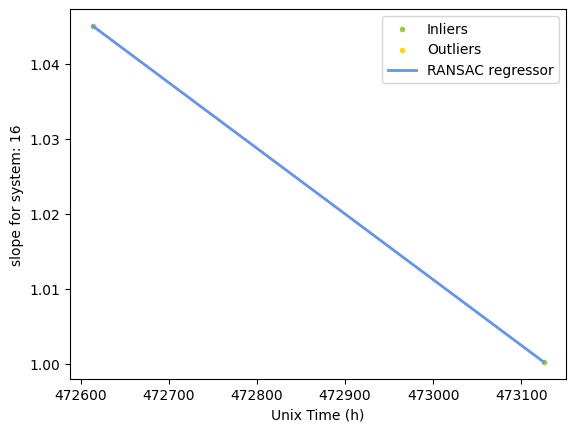

shape: (2, 7)
┌────────────┬───────────────────┬──────────┬────────────┬──────────────────┬───────────────┬──────┐
│ date       ┆ system_name       ┆ slope    ┆ intercept  ┆ creation_timesta ┆ timestamp     ┆ mask │
│ ---        ┆ ---               ┆ ---      ┆ ---        ┆ mp               ┆ ---           ┆ ---  │
│ date       ┆ str               ┆ f64      ┆ f64        ┆ ---              ┆ f64           ┆ bool │
│            ┆                   ┆          ┆            ┆ datetime[μs,     ┆               ┆      │
│            ┆                   ┆          ┆            ┆ UTC]             ┆               ┆      │
╞════════════╪═══════════════════╪══════════╪════════════╪══════════════════╪═══════════════╪══════╡
│ 2023-12-01 ┆ tum-esm-midcost-r ┆ 1.045095 ┆ -44.142526 ┆ 2023-12-01       ┆ 472613.364897 ┆ true │
│            ┆ aspi-16           ┆          ┆            ┆ 05:21:53.630 UTC ┆               ┆      │
│ 2023-12-22 ┆ tum-esm-midcost-r ┆ 1.000234 ┆ -26.945203 ┆ 2023-12-22       ┆

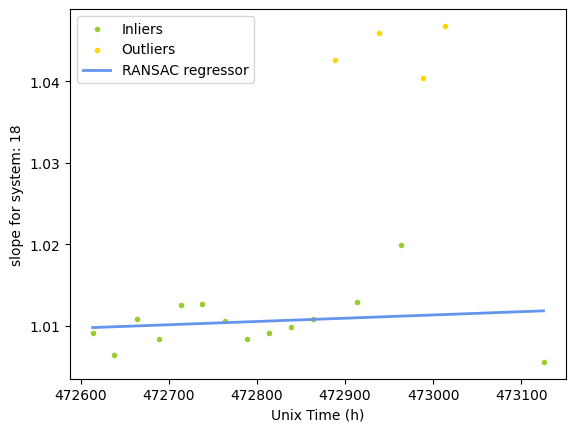

shape: (18, 7)
┌────────────┬──────────────────┬──────────┬────────────┬──────────────────┬───────────────┬───────┐
│ date       ┆ system_name      ┆ slope    ┆ intercept  ┆ creation_timesta ┆ timestamp     ┆ mask  │
│ ---        ┆ ---              ┆ ---      ┆ ---        ┆ mp               ┆ ---           ┆ ---   │
│ date       ┆ str              ┆ f64      ┆ f64        ┆ ---              ┆ f64           ┆ bool  │
│            ┆                  ┆          ┆            ┆ datetime[μs,     ┆               ┆       │
│            ┆                  ┆          ┆            ┆ UTC]             ┆               ┆       │
╞════════════╪══════════════════╪══════════╪════════════╪══════════════════╪═══════════════╪═══════╡
│ 2023-12-01 ┆ tum-esm-midcost- ┆ 1.009097 ┆ -4.001133  ┆ 2023-12-01       ┆ 472613.365881 ┆ true  │
│            ┆ raspi-18         ┆          ┆            ┆ 05:21:57.170 UTC ┆               ┆       │
│ 2023-12-02 ┆ tum-esm-midcost- ┆ 1.006386 ┆ -3.237947  ┆ 2023-12-02       ┆

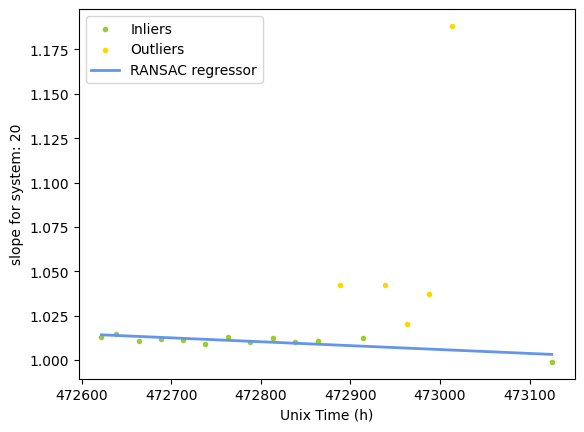

shape: (18, 7)
┌────────────┬──────────────────┬──────────┬────────────┬──────────────────┬───────────────┬───────┐
│ date       ┆ system_name      ┆ slope    ┆ intercept  ┆ creation_timesta ┆ timestamp     ┆ mask  │
│ ---        ┆ ---              ┆ ---      ┆ ---        ┆ mp               ┆ ---           ┆ ---   │
│ date       ┆ str              ┆ f64      ┆ f64        ┆ ---              ┆ f64           ┆ bool  │
│            ┆                  ┆          ┆            ┆ datetime[μs,     ┆               ┆       │
│            ┆                  ┆          ┆            ┆ UTC]             ┆               ┆       │
╞════════════╪══════════════════╪══════════╪════════════╪══════════════════╪═══════════════╪═══════╡
│ 2023-12-01 ┆ tum-esm-midcost- ┆ 1.01272  ┆ -11.70645  ┆ 2023-12-01       ┆ 472621.898283 ┆ true  │
│            ┆ raspi-20         ┆          ┆            ┆ 13:53:53.820 UTC ┆               ┆       │
│ 2023-12-02 ┆ tum-esm-midcost- ┆ 1.014783 ┆ -15.863671 ┆ 2023-12-02       ┆

In [42]:
l_df_cor = []

for id in system_ids:
    try:
        df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

        y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
        x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()
        d = df_sys.select(pl.col("creation_timestamp")).collect().to_series().to_list()
        mask = fit_ransac(x,y,d)

        df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
        
        l_df_cor.append(df_sys)
    except Exception as e:
        print(e)
        print(f"Could not find calibrations for system {id}")
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [43]:
df_cal_ransac = df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .filter(pl.col("mask") == True) \
    .sort("creation_timestamp") \
    .lazy()
    
df_cal_ransac.head(3).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp,mask,ransac_slope,ransac_intercept
date,str,f64,f64,"datetime[μs, UTC]",f64,bool,f64,f64
2023-12-01,"""tum-esm-midcos…",0.995592,27.799895,2023-12-01 05:20:46.340 UTC,472613.346206,true,0.995592,27.799895
2023-12-01,"""tum-esm-midcos…",1.045095,-44.142526,2023-12-01 05:21:53.630 UTC,472613.364897,true,1.045095,-44.142526
2023-12-01,"""tum-esm-midcos…",1.009097,-4.001133,2023-12-01 05:21:57.170 UTC,472613.365881,true,1.009097,-4.001133


In [44]:
df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [45]:
# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")
    
        
l_df_cal_corr =[df_p_1h]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='1h')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))


In [46]:
import plotly.express as px

fig = px.line(df_cal_corr_agg, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2 Dry", color="system_name")
fig.show()

fig = px.line(df_cal_corr_agg, x="creation_timestamp", y=f"diff", markers=True, title = "Difference Acropolis System - PICARRO", color="system_name")
fig.show()

In [47]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    df_acropolis = df_cal_corr_agg.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_corr_agg.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
        print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 12:
Offset 3.7828969924200506
RMSE: 25.37031879720662
R2: 0.43426381917676493

Analysis for System 16:
Offset -8.477052128328909
RMSE: 26.159542876979103
R2: 0.3985183164521068

Analysis for System 18:
Offset -4.671919364484783
RMSE: 22.200208898765624
R2: 0.566812189522274

Analysis for System 20:
Offset -6.784990052526742
RMSE: 25.71249097453955
R2: 0.4179005652800114


# Substract mean offset

In [48]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_corr_agg.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_corr_agg.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 12:
RMSE: 25.08670496929868
R2: 0.4468418060368422

Analysis for System 16:
RMSE: 24.747954880072463
R2: 0.46167972592271656

Analysis for System 18:
RMSE: 21.703051504352665
R2: 0.5859967910051687

Analysis for System 20:
RMSE: 24.801131064991598
R2: 0.45843343040560947
